RFM 분석 기법을 이용하여 고객 세분화를 어떻게 하는지 살펴보고,
K-평균 군집화 알고리즘으로 사용자 세부화 모델 구현해보기.

*RFM은 고객 관리할 때 사용하는 기법이며 구매 최신성(Recency), 구매 빈도(Frequency), 구매 금액(Monetary)를 따서 RFM이라고 부른다.

데이터세트 출처
https://archive.ics.uci.edu/ml/datasets/Online+Retail+II

1) 데이터 불러오기 및 전처리하기
2) RFM 분석 기법을 이용한 고객 분류하기
3) K-평균 군집화 알고리즘을 이용한 고객 분류하기


###1) 데이터 불러오기 및 전처리하기

In [2]:
!pip install openpyxl

In [3]:
#필요한 라이브러리 불러오기
import datetime
import numpy as np
import datetime as dt
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

#경고 메시지를 무시하도록 설정하기
import warnings
warnings.filterwarnings("ignore")

In [4]:
#엑셀 파일에서 데이터를 로드해서 데이터프레임으로 저장하기
df = pd.read_excel(
    'https://archive.ics.uci.edu/ml/machine-learning-databases/00502/online_retail_II.xlsx',
    engine="openpyxl"
)

In [5]:
#데이터 프레임의 처음 20개 행 데이터 출력
df.head(20)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom
5,489434,22064,PINK DOUGHNUT TRINKET POT,24,2009-12-01 07:45:00,1.65,13085.0,United Kingdom
6,489434,21871,SAVE THE PLANET MUG,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom
7,489434,21523,FANCY FONT HOME SWEET HOME DOORMAT,10,2009-12-01 07:45:00,5.95,13085.0,United Kingdom
8,489435,22350,CAT BOWL,12,2009-12-01 07:46:00,2.55,13085.0,United Kingdom
9,489435,22349,"DOG BOWL , CHASING BALL DESIGN",12,2009-12-01 07:46:00,3.75,13085.0,United Kingdom


In [6]:
#데이터 통계량 확인
df.describe()

,Quantity,InvoiceDate,Price,Customer ID
count,525461.000000,525461,525461.000000,417534.000000
mean,10.337667,2010-06-28 11:37:36.845017856,4.688834,15360.645478
min,-9600.000000,2009-12-01 07:45:00,-53594.360000,12346.000000
25%,1.000000,2010-03-21 12:20:00,1.250000,13983.000000
50%,3.000000,2010-07-06 09:51:00,2.100000,15311.000000
75%,10.000000,2010-10-15 12:45:00,4.210000,16799.000000
max,19152.000000,2010-12-09 20:01:00,25111.090000,18287.000000
std,107.424110,NaN,146.126914,1680.811316


In [7]:
#데이터 결측치 확인
#결측치의 합계를 구해서 내림차순으로 정렬
df.isnull().sum().sort_values(ascending=False)

,0
Customer ID,107927
Description,2928
StockCode,0
Invoice,0
Quantity,0
InvoiceDate,0
Price,0
Country,0


In [8]:
#데이터 세트에서 값이 이상한 데이터와 중복 데이터 제거
#제품 수량과 가격이 0 이하인 데이터 제거하기

df = df[ (df['Quantity']>0) & ( df['Price'] > 0 )]


In [9]:
#중복데이터 제거하기
df = df.drop_duplicates()

###2) RFM 분석 기법을 이용한 고객 분류하기

(1) RFM 지표 계산하기

데이터에서 RFM 지표가 의미하는 것은 다음과 같다.

**Recency(구매최신성)** : 고객이 가장 최근에 트랜젝션을 수행한 이후 경과된 시간이며, 일 단위로 측정됨.

**Frequency(구매 빈도)** : 고객이 수행한 총 트랜젝션 수

**Monetary(구매 금액)** : 고객이 모든 거래에서 지출한 총 금액

In [10]:
#최신성(Recency) 값을 계산하기 위해 마지막 날짜의 다음 날을 계산하기
# datetime.timedelta(days=1)는 하루 뒤를 표현하는 객체

last_date = df.InvoiceDate.max() + datetime.timedelta(days=1)

In [11]:
last_date


Timestamp('2010-12-10 20:01:00')

In [12]:
#구매 수량과 제품 가격을 곱하여 구매 금액을 계산하기
df['Amount'] = df['Quantity'] + df['Price']

In [13]:
#groupby 함수로 고객별로 최근 구매 경과일, 구매 건수, 구매 금액 합계를 구하기

rfm = df.groupby('Customer ID').agg(
    {'InvoiceDate' : lambda InvoiceDate : (last_date - InvoiceDate.max()).days,
     'Invoice' : lambda Invoice : Invoice.nunique(),
     'Amount' : lambda Amount : Amount.sum()
     }
)

"""
agg:
agg는 그룹별로 어떤 요약 통계를 낼지 지정하는 함수입니다.
즉, 각 컬럼마다 다른 계산을 적용할 수 있어요.

nunique:
고유한 값(unique value)의 개수를 셉니다.
(※ null 값은 기본적으로 제외됩니다.)
"""

rfm.head()

,InvoiceDate,Invoice,Amount
Customer ID,,,
12346.0,165,11,276.36
12347.0,3,2,990.95
12348.0,74,1,387.39
12349.0,43,3,1868.34
12351.0,11,1,310.46


In [14]:
#데이터 프레임의 칼럼명 변경하기
rfm.columns = ['recency', 'frequency', 'monetary']
rfm.head()

,recency,frequency,monetary
Customer ID,,,
12346.0,165,11,276.36
12347.0,3,2,990.95
12348.0,74,1,387.39
12349.0,43,3,1868.34
12351.0,11,1,310.46


###2) RFM 분석 기법을 이용한 고객 분류하기

(2) 고객 점수 계산하기

: 각 고객에 대해, 구매 최신성, 구매 빈도, 구매 금액을 1에서 5까지 점수로 환산하고, 이를 모두 합산하여 고객 점수 계산하기. 판다스의 qcut() 함수로 구매 최신성, 구매 빈도, 구매 금액을 5개 구간으로 나누고, 각 구간에 1에서 5까지 점수를 부여하기.

In [15]:
#구매 최신성, 구매 빈도, 구매 금액을 1에서 5까지 점수로 환산하기

rfm['recency_score'] = pd.qcut(rfm['recency'], 5, labels=[5,4,3,2,1]).astype(int)

rfm['frequency_score'] = pd.qcut(rfm['frequency'].rank(method='first'), 5, labels=[1,2,3,4,5]).astype(int)

rfm['monetary_score'] = pd.qcut(rfm['monetary'], 5, labels=[1,2,3,4,5]).astype(int)

In [16]:
#구매 최신성, 구매 빈도, 구매 금액의 환산 점수 합계를 고객 점수로 저장한다.
rfm['customer_score'] = rfm['recency_score'] + \
rfm['frequency_score'] + rfm['monetary_score']

In [17]:
#데이터 확인하기
rfm.head(10)

,recency,frequency,monetary,recency_score,frequency_score,monetary_score,customer_score
Customer ID,,,,,,,
12346.0,165,11,276.36,2,5,2,9
12347.0,3,2,990.95,5,2,4,11
12348.0,74,1,387.39,2,1,2,5
12349.0,43,3,1868.34,3,3,5,11
12351.0,11,1,310.46,5,1,2,8
12352.0,11,2,242.60,5,2,2,9
12353.0,44,1,230.78,3,1,2,6
12355.0,203,1,355.78,1,1,2,4
12356.0,16,3,2084.43,4,3,5,12


In [18]:
#customer_score로 회사 매출에 도움이 되는 고객 확인하기
#고객 점수가 만점(15)인 고객 확인하기

rfm[ rfm['customer_score'] == 15].sort_values('monetary', ascending=False).head()

,recency,frequency,monetary,recency_score,frequency_score,monetary_score,customer_score
Customer ID,,,,,,,
14646.0,10,78,174537.99,5,5,5,15
13694.0,9,94,127541.43,5,5,5,15
14156.0,7,102,126783.87,5,5,5,15
18102.0,1,89,126405.44,5,5,5,15
14911.0,1,205,101269.54,5,5,5,15


In [19]:
#custormet_score에 따라 고객을 4단계로 분류
#고객 등급 분류 함수 만들기
def level (score) :
    if score > 12 :
      return 'VIP'
    elif 9 < score <= 12 :
      return 'GOLD'
    elif 5 < score <= 9 :
      return 'SILVER'
    else :
      return 'WHITE'

In [20]:
#고객 등급 분류 함수를 적용하여 고객 등급 데이터 생성하기
rfm['level'] = rfm['customer_score'].apply(
    lambda customer_score : level(customer_score)
)

In [21]:
rfm.head()

,recency,frequency,monetary,recency_score,frequency_score,monetary_score,customer_score,level
Customer ID,,,,,,,,
12346.0,165,11,276.36,2,5,2,9,SILVER
12347.0,3,2,990.95,5,2,4,11,GOLD
12348.0,74,1,387.39,2,1,2,5,WHITE
12349.0,43,3,1868.34,3,3,5,11,GOLD
12351.0,11,1,310.46,5,1,2,8,SILVER


<Axes: xlabel='level', ylabel='count'>

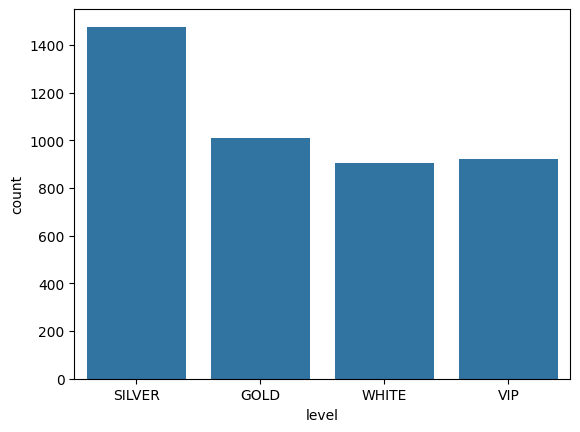

In [22]:
sns.countplot(x=rfm['level'])

###3)K-평균 군집화 알고리즘을 이용한 고객 분류하기


전체 클러스터는 recency(구매 최신성), frequency(구매 빈도), monetary(구매 금액) 3가지 요소를 기반으로 한다.

In [23]:
#데이터 프레임의 요약 통계량 확인하기
rfm.describe()

,recency,frequency,monetary,recency_score,frequency_score,monetary_score,customer_score
count,4312.000000,4312.000000,4312.000000,4312.000000,4312.000000,4312.000000,4312.000000
mean,91.171846,4.455705,1587.415722,3.024814,3.000000,3.000000,9.024814
std,96.860633,8.170213,6792.984783,1.424049,1.414706,1.414706,3.578472
min,1.000000,1.000000,3.950000,1.000000,1.000000,1.000000,3.000000
25%,18.000000,1.000000,241.500000,2.000000,2.000000,2.000000,6.000000
50%,53.000000,2.000000,552.495000,3.000000,3.000000,3.000000,9.000000
75%,136.000000,5.000000,1359.125000,4.000000,4.000000,4.000000,12.000000
max,374.000000,205.000000,220652.100000,5.000000,5.000000,5.000000,15.000000


####(1) 이상치 제거하기

In [24]:
"""
이상치를 구하기 위해서 중간 50%데이터가 분포하는 범위를 나타내는
사분위수 범위(InterQuartile Range, IQR)를 먼저 계산한다.
이상치는 Q1-1.5*IQR 보다 작거나, Q3+1.5*IQR 보다 큰 값들이다.
칼럼에 쉽게 적용할 수 있는 이상치 제거 함수를 작성해본다.

분위수(quantile) :
데이터를 “비율(%)”로 나누는 기준점
즉, 데이터를 크기순으로 정렬했을 때
상위 몇 % 지점에 있는 값인가? 를 알려주는 거예요.

"""

#이상치 제거 함수 작성하기

def processing_outlier(df, col_nm) :
  Q1 = df[col_nm].quantile(0.25)
  Q3 = df[col_nm].quantile(0.75)
  IQR = Q3 - Q1

  df = df[ (df[col_nm] >= Q1 - 1.5*IQR) & (df[col_nm] <= Q3 + 1.5*IQR)]

  return df

In [25]:
#비교를 위해 이상치 제거 전 데이터 저장하기

rfm_tmp = rfm.copy()

'\n위 코드는 한꺼번에 써야지\n하나씩 쓰니까 안 나온다.\n'

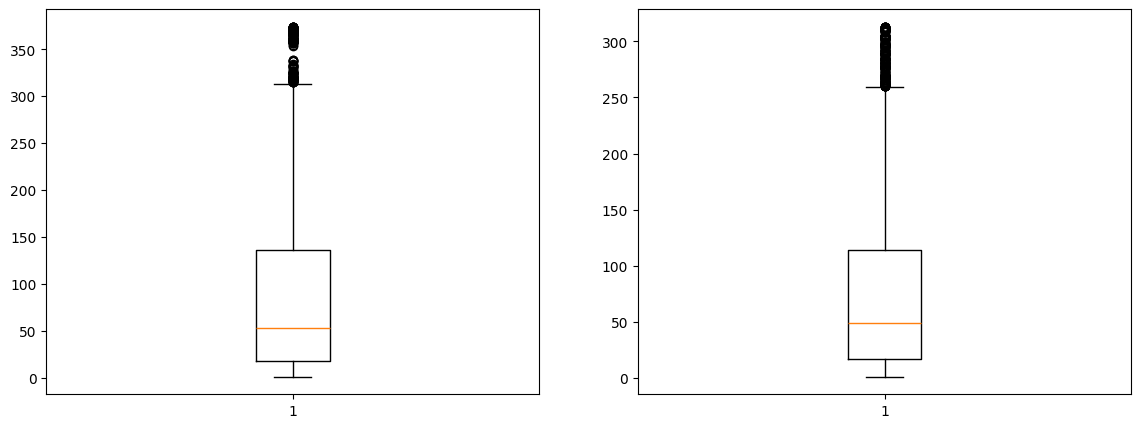

In [26]:
# recency 컬럼의 이상치를 제고하고, 이상치 제거 전후의 recency 데이터의 분포를 시각화 및 비교한다.

# recency 이상치 제거하기
rfm = processing_outlier(rfm, 'recency')

# 이상치 제거 전후 비교하기
fig = plt.figure(figsize=(14,5)) #그림 사이즈 지정(가로 14인치, 세로 5인치)
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

#이상치 제거 전 그래프 시각화
ax1.boxplot(rfm_tmp.recency)

#이상치 제거 후 그래프 시각화
ax2.boxplot(rfm.recency)

"""
위 코드는 한꺼번에 써야지
하나씩 쓰니까 안 나온다.
"""

{'whiskers': [<matplotlib.lines.Line2D at 0x7fe77d3c5b80>,
 'caps': [<matplotlib.lines.Line2D at 0x7fe77d3c6180>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fe77d3c5880>],
 'medians': [<matplotlib.lines.Line2D at 0x7fe77d3c6750>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fe77d3c69c0>],
 'means': []}

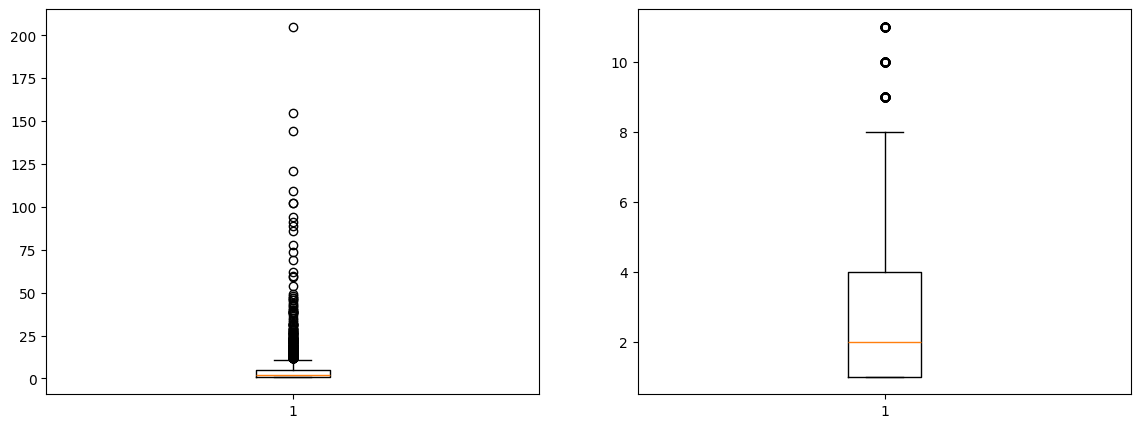

In [27]:
# frequency 컬럼의 이상치를 제고하고, 이상치 제거 전후의 frequency 데이터의 분포를 시각화 및 비교한다.

# recency 이상치 제거하기
rfm = processing_outlier(rfm, 'frequency')

# 이상치 제거 전후 비교하기
fig = plt.figure(figsize=(14,5)) #그림 사이즈 지정(가로 14인치, 세로 5인치)
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

#이상치 제거 전 그래프 시각화
ax1.boxplot(rfm_tmp.frequency)

#이상치 제거 후 그래프 시각화
ax2.boxplot(rfm.frequency)


{'whiskers': [<matplotlib.lines.Line2D at 0x7fe783d18530>,
 'caps': [<matplotlib.lines.Line2D at 0x7fe783d18b00>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fe783d18200>],
 'medians': [<matplotlib.lines.Line2D at 0x7fe783d190a0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fe783d19370>],
 'means': []}

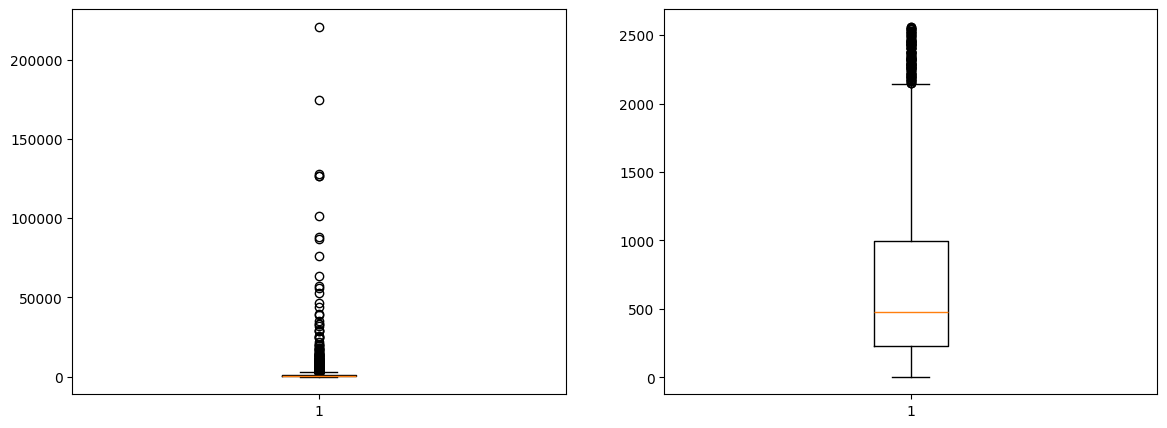

In [28]:
# monetary 컬럼의 이상치를 제고하고, 이상치 제거 전후의 monetary 데이터의 분포를 시각화 및 비교한다.

# monetary 이상치 제거하기
rfm = processing_outlier(rfm, 'monetary')

# 이상치 제거 전후 비교하기
fig = plt.figure(figsize=(14,5)) #그림 사이즈 지정(가로 14인치, 세로 5인치)
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

#이상치 제거 전 그래프 시각화
ax1.boxplot(rfm_tmp.monetary)

#이상치 제거 후 그래프 시각화
ax2.boxplot(rfm.monetary)

####(2) 표준화
312p ~

In [29]:
#사이킷런 StandardScaler 객체로 데이터에 표준화 적용
#StandardScaler는 특성들의 평균을 0, 분산을 1로 스케일링하여 정규 분포로 만든다.

rfm_k = rfm[['recency', 'frequency', 'monetary' ]]

#데이터 표준화하기
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_k)

print(rfm_scaled)

[[ 0.92327112  3.63336555 -0.68885036]
 [-1.00457255 -0.40466305  0.5120665 ]
 [-0.15965341 -0.85333289 -0.50225693]
 ...
 [ 2.48220644 -0.85333289 -0.74121685]
 [ 0.29255684 -0.40466305  0.34963963]
 [-0.82606851  0.49267664  1.6512225 ]]


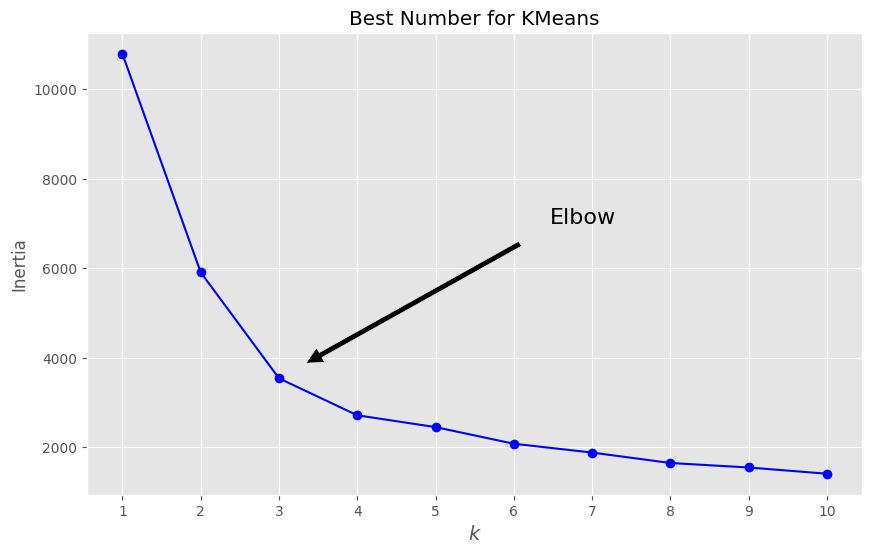

In [32]:
#최적의 군집 수를 알기 위해 k를 1~10까지 증가시키면서 이너셔를 시각화한다.

ks = range(1, 11)
inertias = []

for k in ks :
  kc = KMeans(n_clusters=k, random_state=42)
  kc.fit(rfm_scaled)
  cluster = kc.fit_predict(rfm_scaled)
  inertias.append(kc.inertia_)

# k vs inertia 그래프 그리기
plt.subplots(figsize=(10,6))
plt.plot(ks, inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel('Inertia')
plt.annotate('Elbow',
             xy=(3, inertias[2]),
             xytext=(0.55, 0.55),
             textcoords="figure fraction",
             fontsize=16,
             arrowprops=dict(facecolor='black', shrink=0.1)
             )
plt.xticks(ks)
plt.style.use('ggplot')
plt.title('Best Number for KMeans')
plt.show()


In [34]:
# 이너셔를 그린 그래프에서 감소하는 속도가 꺾이는 지점이 최적의 군집 개수이다.
# k=3으로 설정하고 군집의 중심을 구한다.

# k를 3으로 설정하고 군집 중심 찾기
kc = KMeans(3, random_state=42)
kc.fit(rfm_scaled)

identified_clusters = kc.fit_predict(rfm_k)
clusters_scaled = rfm_k.copy()
clusters_scaled['cluster_pred'] = kc.fit_predict(rfm_scaled)

print(f'Identified Clusters : {identified_clusters}')
print(f'Cluster Centers : \n{kc.cluster_centers_}')

Identified Clusters : [0 2 0 ... 0 2 1]
Cluster Centers : 
[[ 1.58974316 -0.61236069 -0.59402808]
 [-0.55439879  1.39367254  1.40825687]
 [-0.44789744 -0.35989032 -0.37451952]]


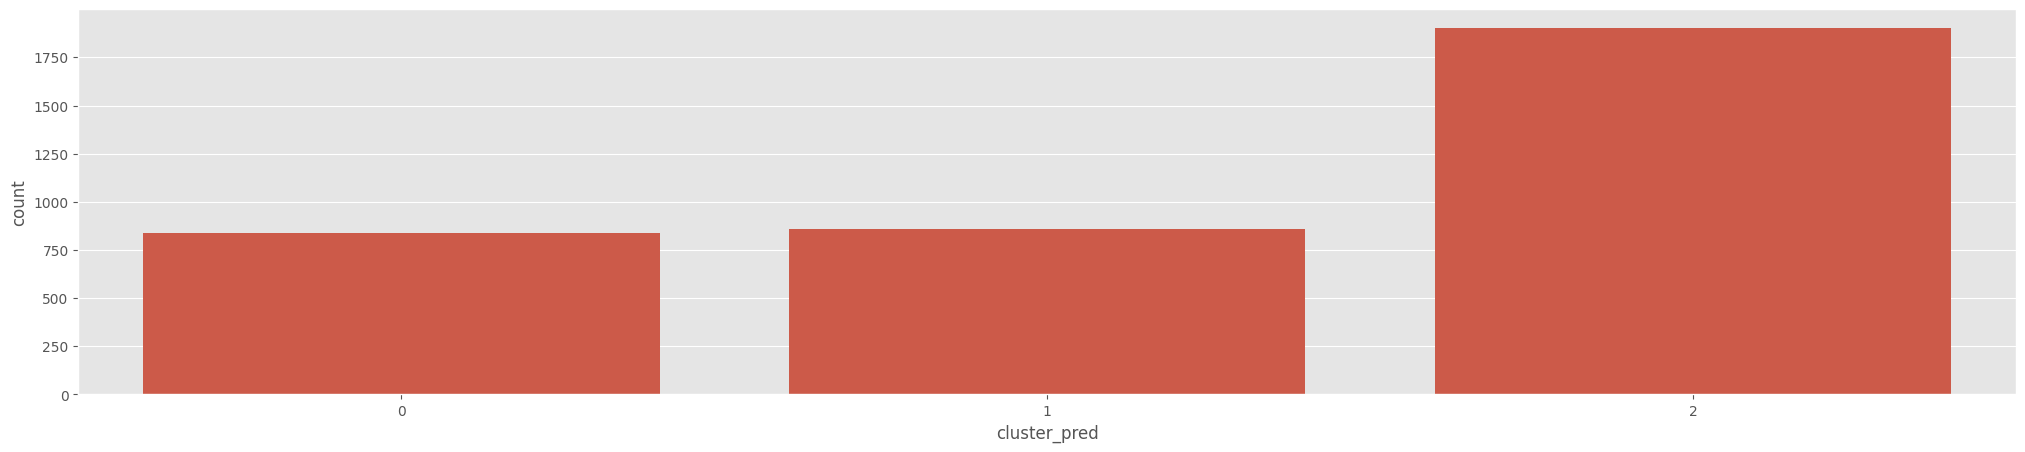

In [35]:
# cluster_pred 칼럼의 값별로 count하기

f, ax = plt.subplots(figsize=(25,5))
ax = sns.countplot(x='cluster_pred', data=clusters_scaled)



In [36]:
#Pandas groupby 함수로 cluster_pred별 개수 집계하기

print( clusters_scaled.groupby(['cluster_pred']).count() )

              recency  frequency  monetary
cluster_pred                              
0                 836        836       836
1                 859        859       859
2                1904       1904      1904


In [37]:
#구매 최신성, 구매 빈도, 구매 금액의 평균값, 최솟값, 최댓값을 구합니다.

rfm_k['cluster'] = clusters_scaled['cluster_pred']
rfm_k['level'] = rfm['level']

#recency, frequency, monetary의 평균값, 최솟값, 최댓값 구하기
rfm_k.groupby('cluster').agg(
    {
        'recency' : ['mean', 'min', 'max'],
        'frequency' : ['mean', 'min', 'max'],
        'monetary' : ['mean', 'min', 'max', 'count']
    }
)

recency           frequency             monetary                   \
               mean  min  max      mean min max         mean     min      max   
cluster                                                                         
0        221.004785  128  313  1.537081   1   8   332.782767    4.75  2122.84   
1         40.828871    1  270  6.008149   1  11  1524.216453  102.15  2560.73   
2         49.778361    1  148  2.099790   1   6   463.398488   11.95  1734.11   

               
        count  
cluster        
0         836  
1         859  
2        1904

####(2)결론

RFM 분석과 K-Means 클러스터링 2가지 방법을 결합하여 고객을 세분화해 보았다.
고객 세분화로 수익성이 높은 고객 그룹을 파악할 수 있으며,
이러한 분석을 통해 어떤 고객 그룹에 특별 제안이나 프로모션을 제공해야 하는지
판단할 수 있다.
